# This Notebook shows an example of HPO
### using Hyperopt of Custom Loss

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
from gbm_custom_loss.catboost.piecewise_loss.biased_piecewise_mse import BiasedPiecewiseMSE
from gbm_custom_loss.catboost.piecewise_loss.piecewise_mse import PiecewiseMSE

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(True)
print("X shape = {}, y shape = {}".format(X.shape, y.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Train {}| Test {}".format(len(X_train), len(X_test)))

X shape = (506, 13), y shape = (506,)
Train 379| Test 127


/home/newuser/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


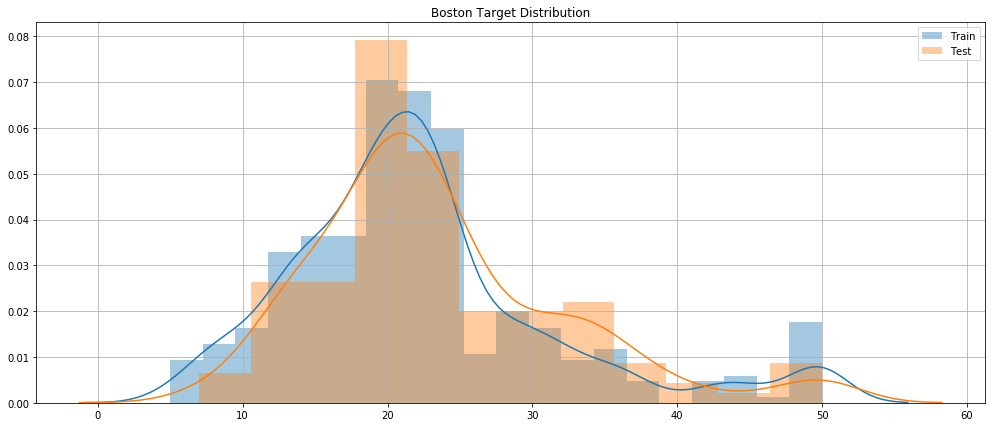

In [3]:
plt.figure(figsize=(17, 7))
plt.title("Boston Target Distribution")
sns.distplot(y_train, label="Train")
sns.distplot(y_test, label="Test")
plt.legend()
plt.grid()

# Metric

For the optimization, let's use the same objective as in the previous example:

Optimize share of predictions where:
* The predicted price is no more than 10 higher the actual price
* The predicted price is no more than 5 lower than actual price

In [4]:
class IntervalMetric(object):
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        approx = approxes[0]
        
        within_interval_n = 0.
        weight_sum = 0.
        for i in range(len(approx)):
            if ((target[i] - approx[i]) < 5) and ((target[i] - approx[i]) > -10):
                within_interval_n += 1
                
            weight_sum = 1.0 if weight is None else weight[i]
            
        return within_interval_n/len(approx), weight_sum
    
    def get_final_error(self, error_sum, weight):
        return error_sum/weight
    
metric = IntervalMetric()

# HPO

Now, we define space and perform HPO over it

In [5]:
from catboost import Pool, CatBoostRegressor

class HPOptimization:
    def __init__(self, X_train, y_train, 
                       X_test, y_test, 
                       space, 
                       max_evals=100):
        self._space = space
        self._max_evals = max_evals
        self._algo = CatBoostRegressor
        self._train_pool = Pool(X_train, y_train)
        self._test_pool = Pool(X_test, y_test)
        self._y_true = y_test
        self.eval_rounds = []
        
    def calc_objective(self, y_pred, y_test):
        return np.mean((y_pred - y_test > -10) & 
                       (y_pred - y_test < 5)).astype(float)
    
    def _update_parameters(self, params):

        params["loss_function"] = PiecewiseMSE(params["coef_bias"])
        del params["coef_bias"]
        return params
    
    def _objective(self, params):
        print("Running {}".format(str(params)))
        params = self._update_parameters(params)
        
        model = self._algo(**params)
        model.fit(self._train_pool, eval_set=self._test_pool)
        y_pred = model.predict(self._test_pool)
        obj = self.calc_objective(y_pred, self._y_true)
        self.eval_rounds.append({'params': params,
                                 'obj': obj,
                                 'y_test': self._y_true,
                                 'y_pred': y_pred})
        print('---------------')
        print("Objective = {:.2f}".format(obj))
        print('=================================\n\n')
        return obj
    
    def optimize(self):
        trials = Trials()
        best = fmin(self._objective,
                    self._space,
                    algo=tpe.suggest,
                    trials=trials,
                    max_evals=self._max_evals,
                    return_argmin=True)
        best = space_eval(self._space, best)
        best = self._update_parameters(best)
        min_idx = np.argmin([self.eval_rounds[i]['obj'] for i in range(len(self.eval_rounds))])
        print("The best score {:.2f} by the best parameters :\n{}".format(trials.best_trial['result']['loss'],
                                                                          str(best)))
        return best, trials.best_trial['result']['loss']

### Defining the space

In [6]:
import numpy as np
from hyperopt import fmin, tpe, STATUS_OK, Trials, space_eval, hp
from copy import copy

hpo_space = {
    'random_seed': 42,
    'max_depth': hp.quniform('max_depth', 4, 12, 1),
    'learning_rate': hp.choice('learning_rate', [0.002, 0.005, 0.01, 0.04, 0.1]),
    'random_strength': hp.uniform('random_strength', 0.0, 100),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, np.log(10)),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'one_hot_max_size': hp.choice('one_hot_max_size', [0, 25, 50, 100, 200]),
    'use_best_model': True,
    'od_wait': 300,
    'verbose': 0,
    'task_type': 'CPU',
    'iterations': 70,
    'eval_metric': metric,
    'loss_function': "BiasedPiecewiseRMSE",
    'coef_bias': {
                    (-1e20, -10): {"coef": hp.uniform('coef_10', 0.0, 20),
                                   "bias": hp.uniform('bias_10', -20, 20),}, 
                     (-10, 5): {"coef": hp.uniform('coef_5', 0.0, 20),
                               "bias": hp.uniform('bias_5', -20, 20)}, 
                     (5, 1e10): {"coef": hp.uniform('coef_inf', 0.0, 20),
                                 "bias": hp.uniform('bias_inf', -20, 20)}, 
                }
        }

MAX_EVALS = 5

In [7]:
hpo = HPOptimization(X_train, y_train, X_test, y_test, 
                     space=hpo_space, 
                     max_evals=MAX_EVALS)
best_params, best_loss = hpo.optimize()

Running {'bagging_temperature': 0.9153675672714743, 'coef_bias': {(-1e+20, -10): {'bias': 15.704523203983754, 'coef': 3.46947346847688}, (-10, 5): {'bias': -2.30694546284964, 'coef': 5.205010081281527}, (5, 10000000000.0): {'bias': -9.845140051775196, 'coef': 9.318135253038875}}, 'eval_metric': <__main__.IntervalMetric object at 0x7f72b7193860>, 'iterations': 70, 'l2_leaf_reg': 8.943417856645963, 'learning_rate': 0.04, 'loss_function': 'BiasedPiecewiseRMSE', 'max_depth': 11.0, 'od_wait': 300, 'one_hot_max_size': 0, 'random_seed': 42, 'random_strength': 70.64839480183339, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 0}
---------------                                    
Objective = 0.90                                   


Running {'bagging_temperature': 0.35932665311658074, 'coef_bias': {(-1e+20, -10): {'bias': 17.30030763060919, 'coef': 15.3530294169237}, (-10, 5): {'bias': 3.3880096516465095, 'coef': 4.664094683560163}, (5, 10000000000.0): {'bias': 17.383161657418334, 'coef

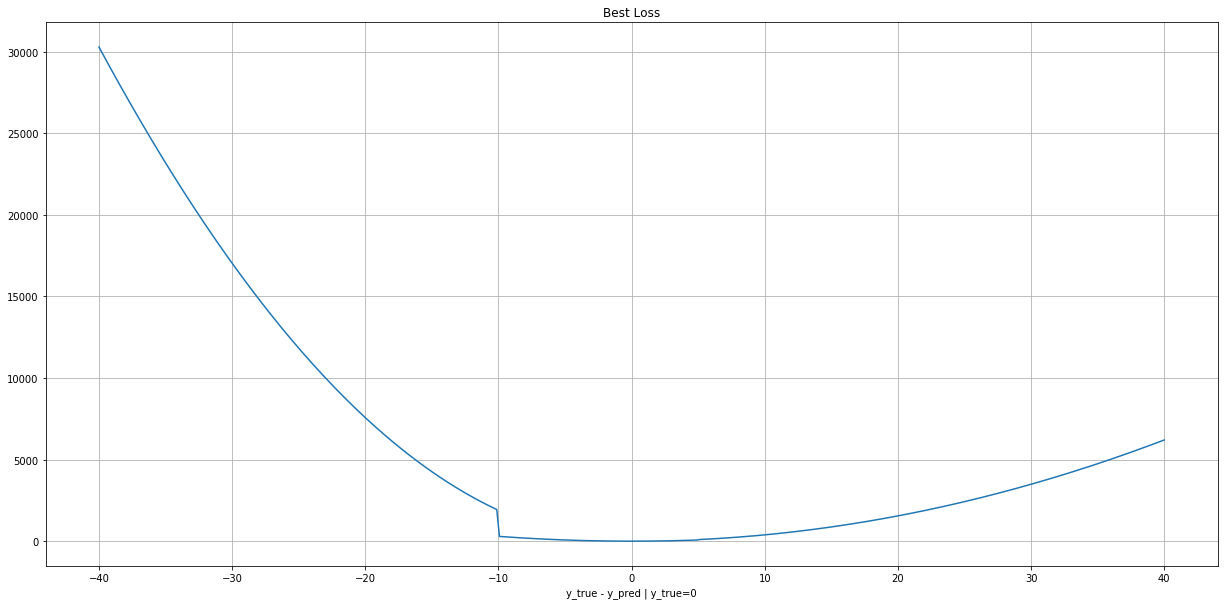

In [8]:
from gbm_custom_loss.utils.visualization import plot_loss
x, y = plot_loss(best_params['loss_function'])
_, ax = plt.subplots(figsize=(21, 10))
ax.set_title("Best Loss")
ax.plot(x, y)
ax.set_xlabel("y_true - y_pred | y_true=0")
ax.grid()